In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table
import subprocess
from pathlib import Path

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.filepaths import GENRMOCKFP_TEMPLATE_FILEPATH, GENRMOCKFP_CPP_FILEPATH
from src.utils.functions import density_contour
from src.A_generate_mocks import generate_genrmockfp_file

def bin_data_rolling(x: np.array, y: np.array, n_bin: int, window_size: float):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(0.00475, 0.05377, n_bin)

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_bin:
        x_lower = x_trial - window_size
        x_upper = x_trial + window_size

        y_ = y[(x >= x_lower) & (x <= x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return x_bin_, y_bin, y_bin_err, y_bin_stderr


def bin_data(x: np.array, y: np.array, xmin: float, xmax: float, n_bin: int):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(xmin, xmax, n_bin)
    x_middle = 0.5 * (x_bin[1:] + x_bin[:-1])
    delta_x = np.diff(x_bin)[0]

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_middle:
        x_lower = x_trial - 0.5 * delta_x 
        x_upper = x_trial + 0.5 * delta_x

        y_ = y[(x >= x_lower) & (x < x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return np.array(x_bin_), np.array(y_bin), np.array(y_bin_err), np.array(y_bin_stderr)

In [33]:
x = np.linspace(1, 10, 10)

(x[1:] + x[:-1]) / 2
(np.diff(x) / 2 )[0]

0.5

# Generate mock with limiting magnitude of 17.0

In [2]:
# Define the config
cfg = {
    "SURVEY": "mock_magnitudes",
    "SMIN_SETTING": "1",
    "FP_FIT_METHOD": "0",
    "SMIN": "2.00",
    "MAG_J_LIMIT": "14.0",
    "NFITS": "5",
    "NGALS_MOCKS": "10000",
    "MEAN_LOGDS": "-3.0",
    "STD_LOGDS": "0.5",
    "a_INPUT_VALUE": "1.5",
    "b_INPUT_VALUE": "-0.85",
    "rmean_INPUT_VALUE": "0.20",
    "smean_INPUT_VALUE": "2.25",
    "imean_INPUT_VALUE": "3.20",
    "sigma1_INPUT_VALUE": "0.05",
    "sigma2_INPUT_VALUE": "0.30",
    "sigma3_INPUT_VALUE": "0.15",
    "EXTINCTION_FILENAME": "/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/data/mocks/extinction_data/all_combined.csv",
    "NGALS_EXTINCTION_DATA": "10000",
    "dI_MAG_SLOPE": "0.06",
    "dI_MAG_CONSTANT": "-0.60",
    "dI_ERR_CONSTANT": "0.05",
    "OUTPUT_FILENAME": "/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/experiments/experiment_014_mock_magnitudes/mock_full.txt"
}

generate_genrmockfp_file(GENRMOCKFP_TEMPLATE_FILEPATH, GENRMOCKFP_CPP_FILEPATH, cfg)

# Run the simulations
GENRMOCKFP_FOLDER_PATH = Path(GENRMOCKFP_CPP_FILEPATH).parent
subprocess.run(['make', 'clean'], cwd=GENRMOCKFP_FOLDER_PATH, capture_output=True, text=True)
subprocess.run(['make', 'genrmockfp'], cwd=GENRMOCKFP_FOLDER_PATH, capture_output=True, text=True)
subprocess.run(['./genrmockfp'], cwd=GENRMOCKFP_FOLDER_PATH, capture_output=True, text=True)

CompletedProcess(args=['./genrmockfp'], returncode=0, stdout='---------------------------------------------------------------------------\nWriting out 5 mocks sample to file: /Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/experiments/experiment_014_mock_magnitudes/mock_full.txt\nEach sample contains 10000 galaxies (per fit)\n\nThe FP parameters for this distribution are: \nslopes   a : 1.5 b : -0.85\nscatter  sigma1: 0.05 sigma2: 0.3 sigma3: 0.15\noffsets  r : 0.2 s : 2.25 i: 3.2\n---------------------------------------------------------------------------\nSurface brightness in luminosity units...\nUsing mag-dependent errors...\nUsing JBAND magnitude\nReading in file: /Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/data/mocks/extinction_data/all_combined.csv\n---------------------------------------------------------------------------\nUpper redshift (distance) limit: < 16120 km/s (29.9323 Mpc/h)\nLower redshift (distance) limit: > 3000 km/s  (159.228 Mpc/h)\nVelocity dis

Text(0, 0.5, 'r')

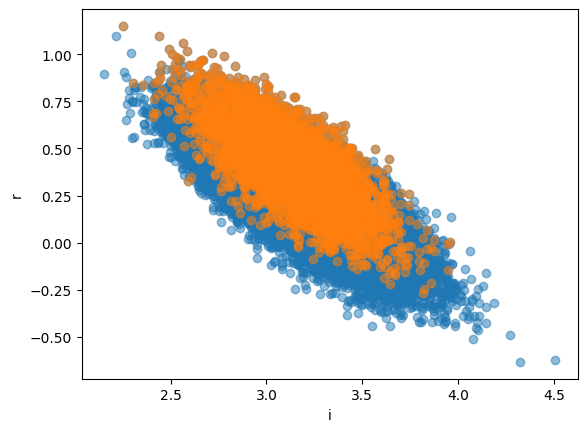

In [3]:
# Load mock data
df_full = pd.read_csv("./mock_full.txt", delim_whitespace=True)

plt.scatter(df_full["i"], df_full["r"], alpha=0.5)

# df = df_full.copy()
# df = df[(df["mag_j"] - df["extinction_j"]) <= 14.0]
# plt.scatter(df["i"], df["r"], alpha=0.5)

# df = df_full.copy()
# df = df[(df["mag_j"] - df["extinction_j"]) <= 13.0]
# plt.scatter(df["i"], df["r"], alpha=0.5)

df = df_full.copy()
df = df[(df["mag_j"] - df["extinction_j"]) <= 11.5]
plt.scatter(df["i"], df["r"], alpha=0.5)
plt.xlabel("i")
plt.ylabel("r")

Text(0, 0.5, 'r')

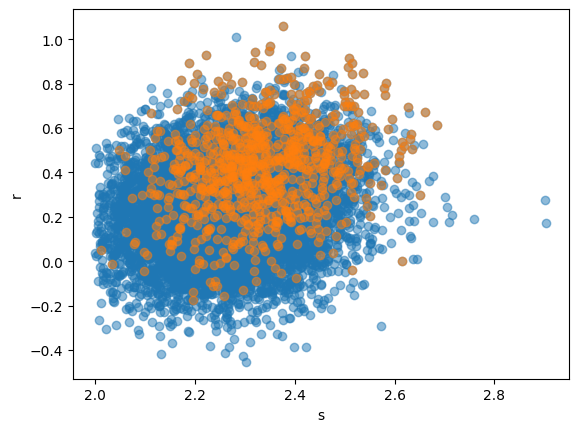

In [9]:
# Load mock data
df_full = pd.read_csv("./mock_full.txt", delim_whitespace=True)

plt.scatter(df_full["s"], df_full["r"], alpha=0.5)

# df = df_full.copy()
# df = df[(df["mag_j"] - df["extinction_j"]) <= 14.0]
# plt.scatter(df["i"], df["r"], alpha=0.5)

# df = df_full.copy()
# df = df[(df["mag_j"] - df["extinction_j"]) <= 13.0]
# plt.scatter(df["i"], df["r"], alpha=0.5)

df = df_full.copy()
df = df[(df["mag_j"] - df["extinction_j"]) <= 11.5]
plt.scatter(df["s"], df["r"], alpha=0.5)
plt.xlabel("s")
plt.ylabel("r")

Text(0, 0.5, 'i')

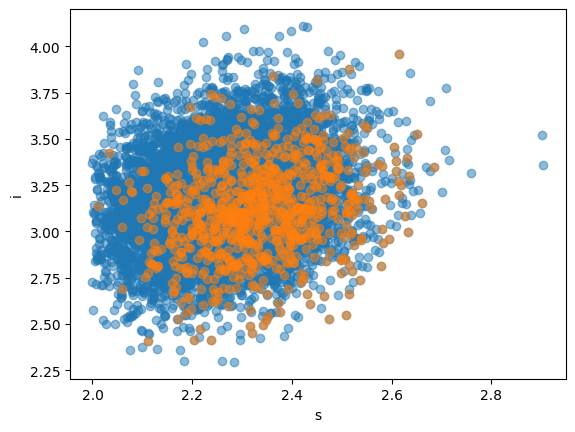

In [10]:
# Load mock data
df_full = pd.read_csv("./mock_full.txt", delim_whitespace=True)

plt.scatter(df_full["s"], df_full["i"], alpha=0.5)

df = df_full.copy()
df = df[(df["mag_j"] - df["extinction_j"]) <= 11.5]
plt.scatter(df["s"], df["i"], alpha=0.5)
plt.xlabel("s")
plt.ylabel("i")

(array([   4.,   13.,   58.,  135.,  336.,  734., 1408., 2217., 2826.,
        2269.]),
 array([ 8.455 ,  9.0087,  9.5624, 10.1161, 10.6698, 11.2235, 11.7772,
        12.3309, 12.8846, 13.4383, 13.992 ]),
 <BarContainer object of 10 artists>)

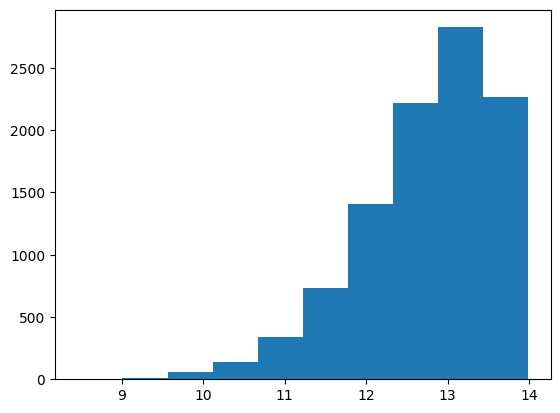

In [22]:
plt.hist(df_full["mag_j"] - df_full["extinction_j"])

# Compare logdist as a function of magnitude limits

In [11]:
# Load base data (magnitude limit of 14.0)
df_base = pd.read_csv("./mock_14.0.csv")[["#mockgal_ID", "z", "logdist"]]

df = df_base.copy()

# Load the rest
mag_lims = ["13.5", "13.0", "12.5", "12.0", "11.0"]
for mag_lim in mag_lims:
    df_ = pd.read_csv(f"./mock_{mag_lim}.csv")[["#mockgal_ID", "logdist"]]
    df_.rename({"logdist": f"logdist_{mag_lim}"}, axis=1, inplace=True)

    df = df.merge(df_, on="#mockgal_ID", how="left")

    # Calculate delta logdists
    df[f"delta_logdist_{mag_lim}"] = df[f"logdist_{mag_lim}"] - df["logdist"]

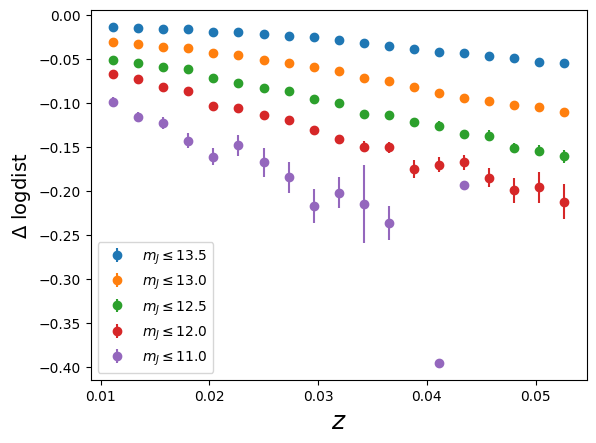

In [43]:
# Bin delta logdist vs redshift
mag_lims = ["13.5", "13.0", "12.5", "12.0", "11.0"]
for mag_lim in mag_lims:
    df_ = df.copy()

    df_ = df_[~df_[f"delta_logdist_{mag_lim}"].isna()]

    x = df_["z"].to_numpy()
    y = df_[f"delta_logdist_{mag_lim}"]

    z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(x, y, xmin=ZMIN, xmax=ZMAX, n_bin=20)

    # plt.scatter(x, y)
    plt.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt="o", label=rf"$m_J \leq {mag_lim}$")
    plt.ylabel(r"$\Delta$ logdist", fontsize=14)
    plt.xlabel(r"$z$", fontsize=18)

plt.legend()

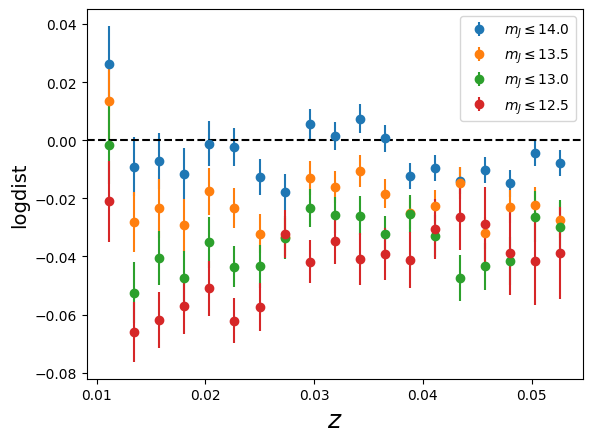

In [41]:
# Bin delta logdist vs redshift
mag_lims = ["14.0", "13.5", "13.0", "12.5"]
for mag_lim in mag_lims:
    df_ = df.copy()
    df_.rename({"logdist": "logdist_14.0"}, axis=1, inplace=True)

    df_ = df_[~df_[f"logdist_{mag_lim}"].isna()]

    x = df_["z"].to_numpy()
    y = df_[f"logdist_{mag_lim}"]

    z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(x=x, y=y, xmin=ZMIN, xmax=ZMAX, n_bin=20)

    # plt.scatter(x, y)
    plt.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt="o", label=rf"$m_J \leq {mag_lim}$")
    plt.ylabel(r"logdist", fontsize=14)
    plt.xlabel(r"$z$", fontsize=18)

plt.axhline(y=0, c='k', ls="--")
plt.legend()

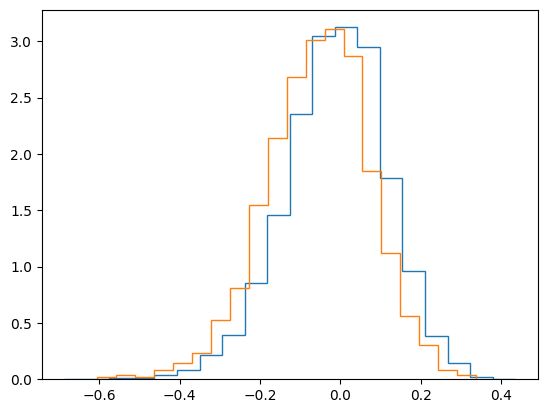

In [26]:
plt.hist(df["logdist"], bins=20, density=True, histtype="step")
plt.hist(df["logdist_12.0"], bins=20, density=True, histtype="step")
plt.show()

# More Mocks

## Full data vs redshift

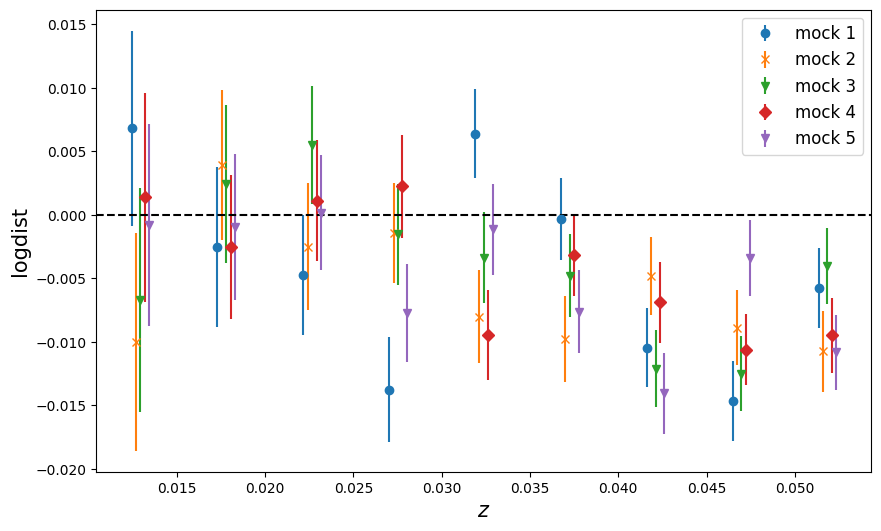

In [ ]:
mag_lims = ["14.0", "13.5", "13.0", "12.5", "12.0"]

mock_shapes = ["o", "x", "v", "D", "v"]

plt.figure(figsize=(10, 6))
for i, mock_id in enumerate([1, 2, 3, 4, 5]):
    # Load mock measured logdist
    df = pd.read_csv(f"./logdists/mock_{mock_id}/mock_14.0.csv")
    x = df["z"].to_numpy()
    y = df["logdist"].to_numpy()

    z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(x=x, y=y, xmin=ZMIN, xmax=ZMAX, n_bin=10)

    plt.errorbar(x=z_bin + i * 0.00025, y=logdist_bin, yerr=logdist_bin_stderr, fmt=mock_shapes[i], label=f"mock {mock_id}")

plt.axhline(y=0, c="k", ls="--")
plt.xlabel(r"$z$", fontsize=15)
plt.ylabel("logdist", fontsize=15)
plt.legend(fontsize=12)

# plt.ylim(-0.4, 0.4)

## Combine logdists for different magnitude limits

In [57]:
mag_lims = ["13.5", "13.0", "12.5", "12.0"]

for mock_id in list(range(1, 6)):
    # Load base data (magnitude limit of 14.0)
    df_base = pd.read_csv(f"./logdists/mock_{mock_id}/mock_14.0.csv")
    df_base.rename({"logdist": "logdist_14.0", "logdist_err": "logdist_err_14.0"}, axis=1, inplace=True)

    df = df_base.copy()

    # Load the rest
    for mag_lim in mag_lims:
        df_ = pd.read_csv(f"./logdists/mock_{mock_id}/mock_{mag_lim}.csv")[["#mockgal_ID", "logdist", "logdist_err"]]
        df_.rename({"logdist": f"logdist_{mag_lim}", "logdist_err": f"logdist_err_{mag_lim}"}, axis=1, inplace=True)

        df = df.merge(df_, on="#mockgal_ID", how="left")

        # Calculate delta logdists
        df[f"delta_logdist_{mag_lim}"] = df[f"logdist_{mag_lim}"] - df["logdist_14.0"]

    # Save combined data
    df.to_csv(f"./logdists/mock_{mock_id}/combined.csv", index=False)

## Different magnitude limits vs redshift

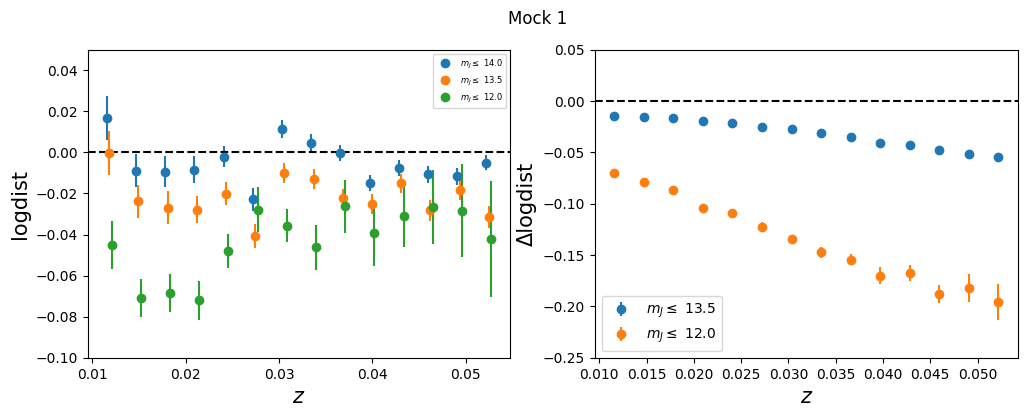

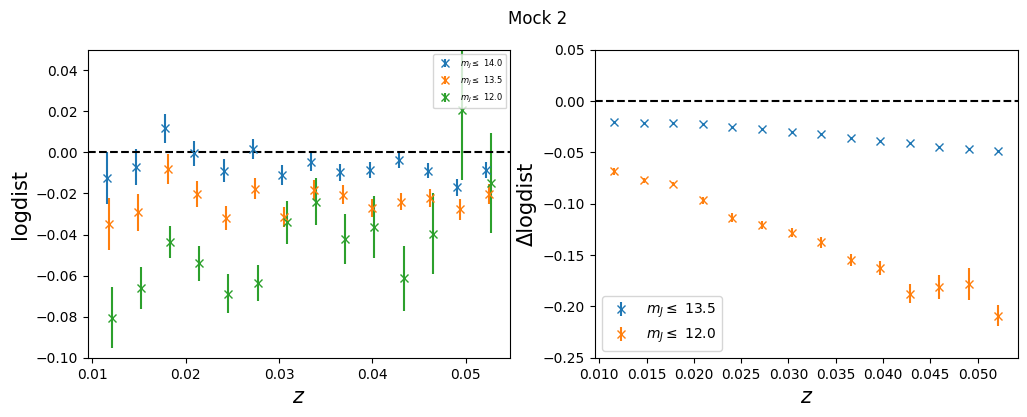

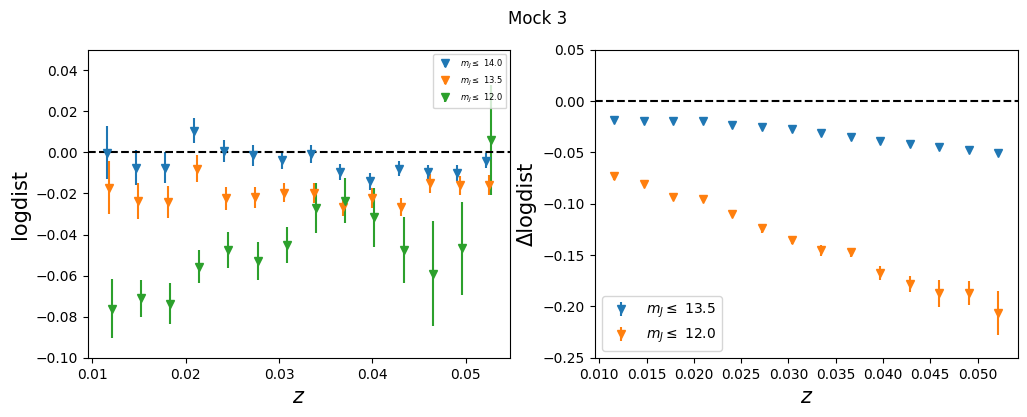

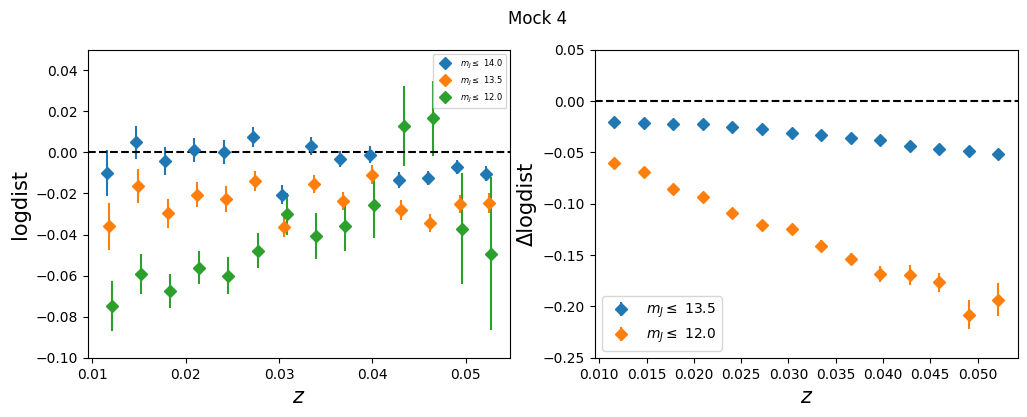

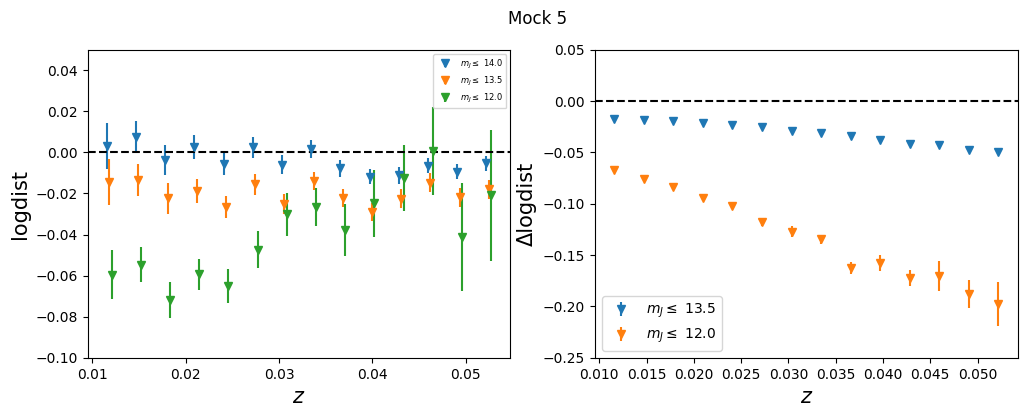

In [4]:
mag_lims = ["14.0", "13.5", "13.0", "12.5", "12.0"]
mag_lims = ["14.0", "13.5", "12.0"]

mock_shapes = ["o", "x", "v", "D", "v"]

for i, mock_id in enumerate([1, 2, 3, 4, 5]):

    # plt.figure(figsize=(10, 6))
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for j, mag_lim in enumerate(mag_lims):
        # Load mock measured logdist
        df = pd.read_csv(f"./logdists/mock_{mock_id}/mock_{mag_lim}.csv")
        x = df["z"].to_numpy()
        y = df["logdist"].to_numpy()

        z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(x=x, y=y, xmin=ZMIN, xmax=ZMAX, n_bin=15)

        ax1.errorbar(x=z_bin + j * 0.00025, y=logdist_bin, yerr=logdist_bin_stderr, fmt=mock_shapes[i], label=rf"$m_J \leq $ {mag_lim}")

    fig.suptitle(f"Mock {mock_id}")
    ax1.axhline(y=0, c="k", ls="--")
    ax1.set_xlabel(r"$z$", fontsize=15)
    ax1.set_ylabel("logdist", fontsize=15)
    ax1.set_ylim(-0.1, 0.05)
    ax1.legend(fontsize=6)

    # Second figure
    df = pd.read_csv(f"./logdists/mock_{mock_id}/combined.csv")
    for j, mag_lim in enumerate(mag_lims):
        if mag_lim == "14.0":
            continue
        df_ = df.copy()

        # Select non nulls
        df_ = df_[~df_[f"logdist_{mag_lim}"].isna()]
        x = df_[f"z"].to_numpy()
        y = df_[f"delta_logdist_{mag_lim}"].to_numpy()

        z_bin, delta_logdist_bin, delta_logdist_bin_err, delta_logdist_bin_stderr = bin_data(x=x, y=y, xmin=ZMIN, xmax=ZMAX, n_bin=15)

        ax2.errorbar(x=z_bin, y=delta_logdist_bin, yerr=delta_logdist_bin_stderr, fmt=mock_shapes[i], label=rf"$m_J \leq $ {mag_lim}")

    ax2.axhline(y=0, c="k", ls="--")
    ax2.set_xlabel(r"$z$", fontsize=15)
    ax2.set_ylabel("Δlogdist", fontsize=15)
    ax2.legend(fontsize=10)
    ax2.set_ylim(-0.25, 0.05)

# plt.ylim(-0.4, 0.4)

# Combine plots for different mocks for delta logdist

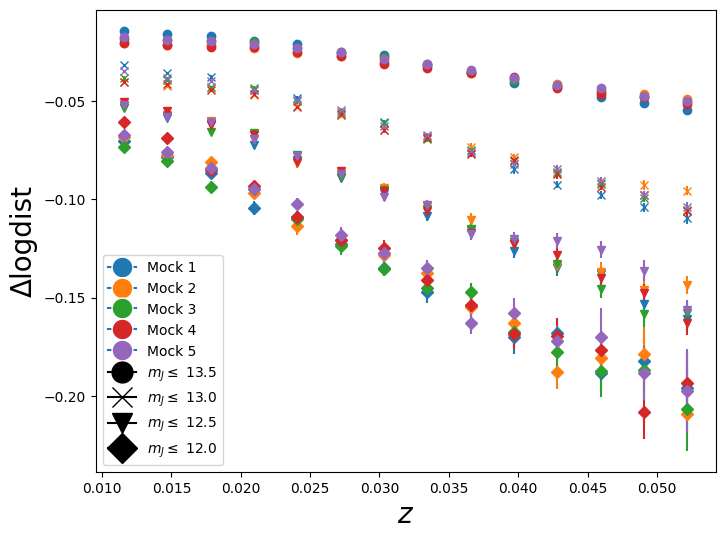

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

colors_ = ["C0", "C1", "C2", "C3", "C4"]
shapes_ = ["o", "x", "v", "D"]

for i, mock_id in enumerate(list(range(1, 6))):
    df = pd.read_csv(f"./logdists/mock_{mock_id}/combined.csv")

    for j, mag_lim in enumerate(["13.5", "13.0", "12.5", "12.0"]):
        df_ = df.copy()
        df_ = df_[~df_[f"delta_logdist_{mag_lim}"].isna()]

        x = df_["z"].to_numpy()
        y = df_[f"delta_logdist_{mag_lim}"]

        z_bin, delta_logdist_bin, delta_logdist_bin_err, delta_logdist_bin_stderr = bin_data(x=x, y=y, xmin=ZMIN, xmax=ZMAX, n_bin=15)

        ax.errorbar(x=z_bin, y=delta_logdist_bin, yerr=delta_logdist_bin_stderr, c=colors_[i], fmt=shapes_[j], label=rf"$m_J \leq $ {mag_lim}")


from matplotlib.lines import Line2D

legend_elements = []
for i, mock_id in enumerate(list(range(1, 6))):
    legend_elements.append(Line2D([0], [0], marker="o", label=f'Mock {mock_id}',
                            markerfacecolor=colors_[i], markeredgecolor="white", markersize=15))
    
for j, mag_lim in enumerate(["13.5", "13.0", "12.5", "12.0"]):
    legend_elements.append(Line2D([0], [0], marker=shapes_[j], label=rf'$m_J \leq $ {mag_lim}',
                            color="k", markersize=15))

# Create the figure
ax.legend(handles=legend_elements, loc='lower left')

ax.set_xlabel(r"$z$", fontsize=20)
ax.set_ylabel("Δlogdist", fontsize=20)

plt.show()

Text(0, 0.5, 'logdist_13.0')

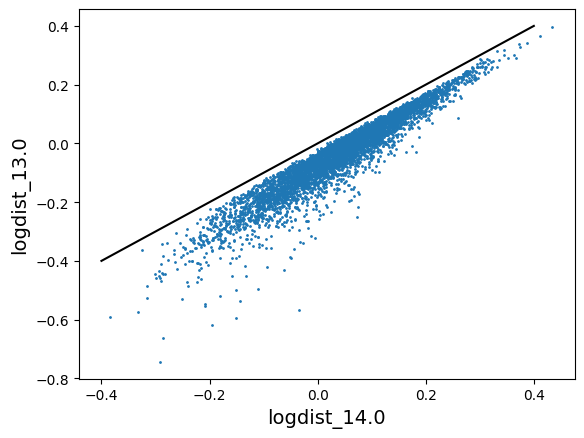

In [82]:
df = pd.read_csv("./logdists/mock_1/combined.csv")

plt.scatter(df["logdist_14.0"], df["logdist_13.0"], s=1)
plt.plot([-0.4, 0.4], [-0.4, 0.4], c='k')

plt.xlabel("logdist_14.0", fontsize=14)
plt.ylabel("logdist_13.0", fontsize=14)

# Logdist shift for positive and negative logdists

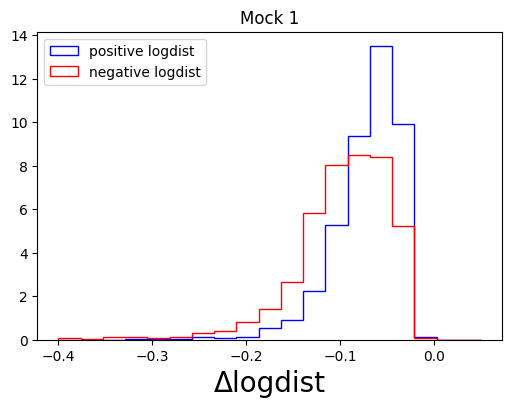

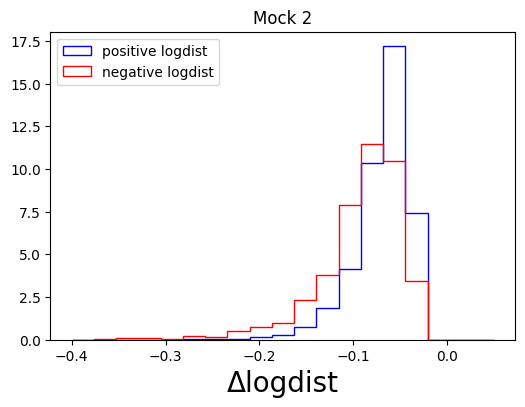

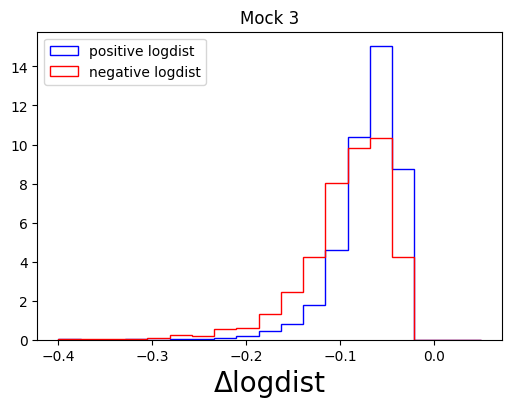

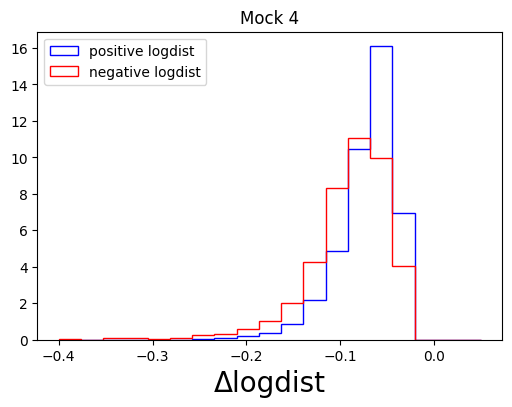

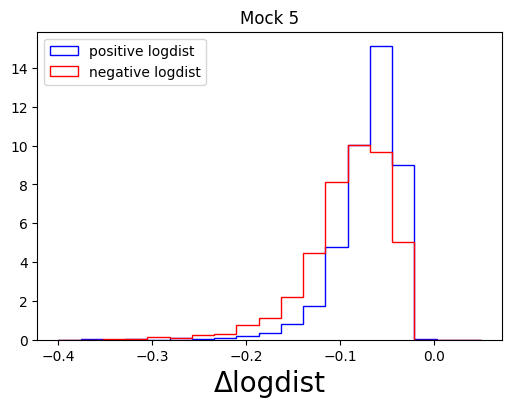

In [2]:
mag_lims = ["14.0", "13.5", "13.0", "12.5", "12.0"]

mock_shapes = ["o", "x", "v", "D", "v"]

for i, mock_id in enumerate([1, 2, 3, 4, 5]):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    
    df = pd.read_csv(f"./logdists/mock_{mock_id}/combined.csv")

    logdist_bins = np.linspace(-0.4, 0.05, 20)

    df_pos = df[df["logdist_14.0"] >= 0]
    df_neg = df[df["logdist_14.0"] < 0]

    ax.hist(df_pos["delta_logdist_13.0"], bins=logdist_bins, color="b", histtype="step", density=True, label="positive logdist")
    ax.hist(df_neg["delta_logdist_13.0"], bins=logdist_bins, color="r", histtype="step", density=True, label="negative logdist")

    # ax.hist(df_pos["delta_logdist_12.0"], bins=logdist_bins, color="b", histtype="step", density=True, label="positive logdist")
    # ax.hist(df_neg["delta_logdist_12.0"], bins=logdist_bins, color="r", histtype="step", density=True, label="negative logdist")

    ax.set_title(f"Mock {mock_id}")
    ax.set_xlabel("Δlogdist", fontsize=20)
    ax.legend()

# Check: logdist distribution vs redshift

/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n

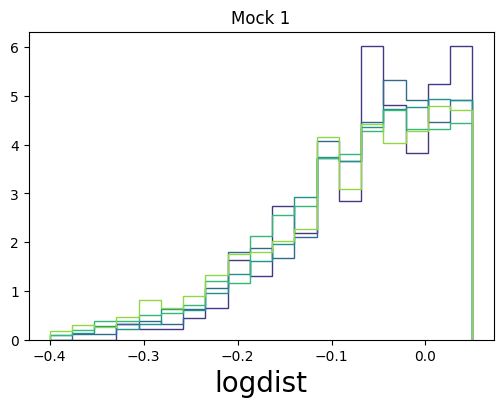

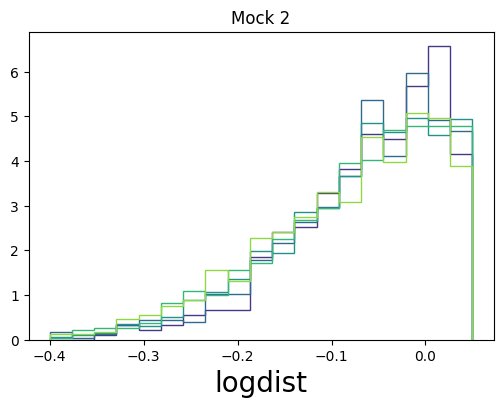

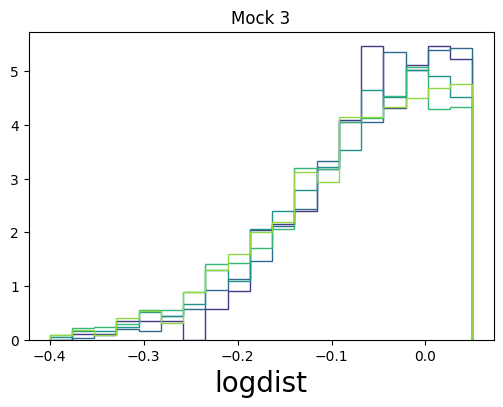

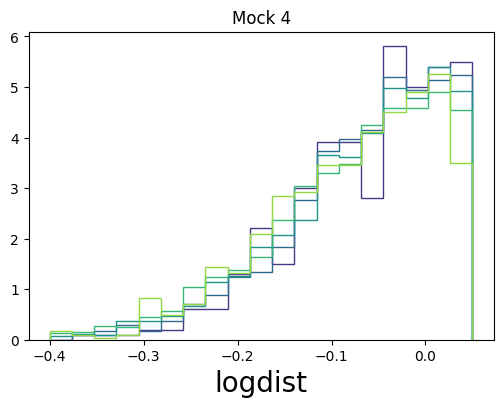

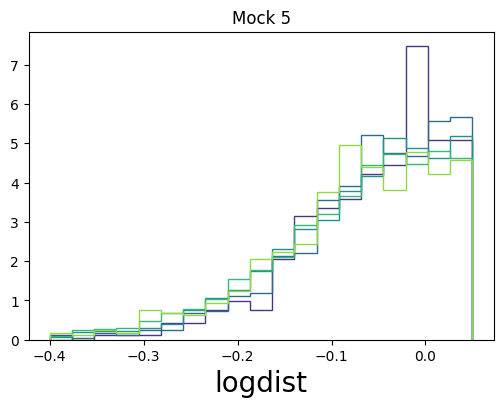

In [3]:
redshift_bins = np.array([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
redshift_bin_middle = 0.5 * (redshift_bins[1:] + redshift_bins[:-1])

for i, mock_id in enumerate([1, 2, 3, 4, 5]):

    df = pd.read_csv(f"./logdists/mock_{mock_id}/combined.csv")

    cmap_ = plt.get_cmap("viridis")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    for j in range(len(redshift_bins) - 1):

        df_ = df.copy()
        df_ = df_[(df_["z"] >= redshift_bins[j]) & (df_["z"] < redshift_bins[j + 1])]

        logdist_bins = np.linspace(-0.4, 0.05, 20)
        ax.hist(df_["logdist_14.0"], bins=logdist_bins, color=cmap_(j / (len(redshift_bins) - 1)), histtype="step", density=True)

    ax.set_title(f"Mock {mock_id}")
    ax.set_xlabel("logdist", fontsize=20)
    # ax.legend()